In [1]:
!pip install pprint ipywidgets pandas numpy matplotlib sklearn seaborn xgboost scipy yellowbrick statsmodels pandas_profiling

Defaulting to user installation because normal site-packages is not writeable


# Gusto

Acute myocardial infarction (“heart attack”) is caused by the formation of a clot in oneof the coronary arteries that supply blood to the heart muscle. 

Acute MI is a major public health problem. Mortality is substantial in the period immediately after the event (and also during the years after surviving the initial  infarction). Some patients die before reaching the  hospital. Patients seen in hospitals are reported to have an average mortality within 30 days around 6–15%, with improvement over time. The risk of 30-day mortality strongly depends on various prognostic factors. In younger patients, risks are much lower than in older patients. Other patient demographics are also important (gender, length, weight), as well as the presence of risk factors (hypertension, diabetes, smoking, family history) and the history of previous cardiovascular events (previous MI, angina, stroke, bypass surgery). Relevant presenting characteristics includethe location of the infarction and the extent of ECG abnormalities. Very important is the acute state of the patients reflected by blood pressure,heart rate, and left ventricular function (e.g., presence of shock).

Aim of this study is to find predictors of 30-days mortality. 

In [1]:
import warnings
warnings.filterwarnings('ignore')

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from pprint import pprint
from time import sleep

#  load data
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn import metrics
from sklearn.metrics import roc_auc_score,f1_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator

from scipy.stats import chi2_contingency

from patsy import dmatrices
import statsmodels.api as sm 

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV


from scipy.special import expit

from yellowbrick.classifier import ConfusionMatrix, ClassBalance, ROCAUC, ClassificationReport, ClassPredictionError

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from pandas_profiling import ProfileReport


In [34]:

df = pd.read_csv("./Gusto.csv")

# dummify smk categories
df['eversmk']= (df['smk']!=1).astype(int)
df['currentsmk']=(df['smk']==3).astype(int)
df.drop(["smk"], axis=1, inplace=True)
df.head()

,day30,sex,age,a65,killip,sho,dia,hyp,hrt,ant,...,wei,htn,lip,pan,fam,ste,st4,ttr,eversmk,currentsmk
0,0,0,70.313,1,1,0,0,0,0,1,...,84.0,1,1,0,0,1,0,1,1,1
1,0,0,59.844,0,1,0,1,0,0,1,...,115.0,1,0,0,1,6,1,0,0,0
2,0,0,59.023,0,1,0,0,0,1,0,...,76.0,1,0,0,1,3,0,0,0,0
3,1,1,80.375,1,1,0,0,0,1,0,...,50.0,0,0,0,0,3,0,0,1,1
4,0,0,64.750,0,1,0,0,1,0,0,...,97.4,0,0,1,1,2,0,1,0,0


In [3]:
profile = ProfileReport(df)
profile.to_widgets()

In [4]:
# any null value?
bool(df.isnull().sum().sum())

False

In [5]:
# dropping useless/redundant columns
df.drop(["sho", "a65", "st4"], axis=1, inplace=True)
df.columns

Index(['day30', 'sex', 'age', 'killip', 'dia', 'hyp', 'hrt', 'ant', 'pmi',
       'hei', 'wei', 'htn', 'lip', 'pan', 'fam', 'ste', 'ttr', 'eversmk',
       'currentsmk'],
      dtype='object')

## Question 1

*Build a descriptive table, comparing patients deadversuspatients alive at 30 days. Insert also a column with the total population descriptive statistics.*




''

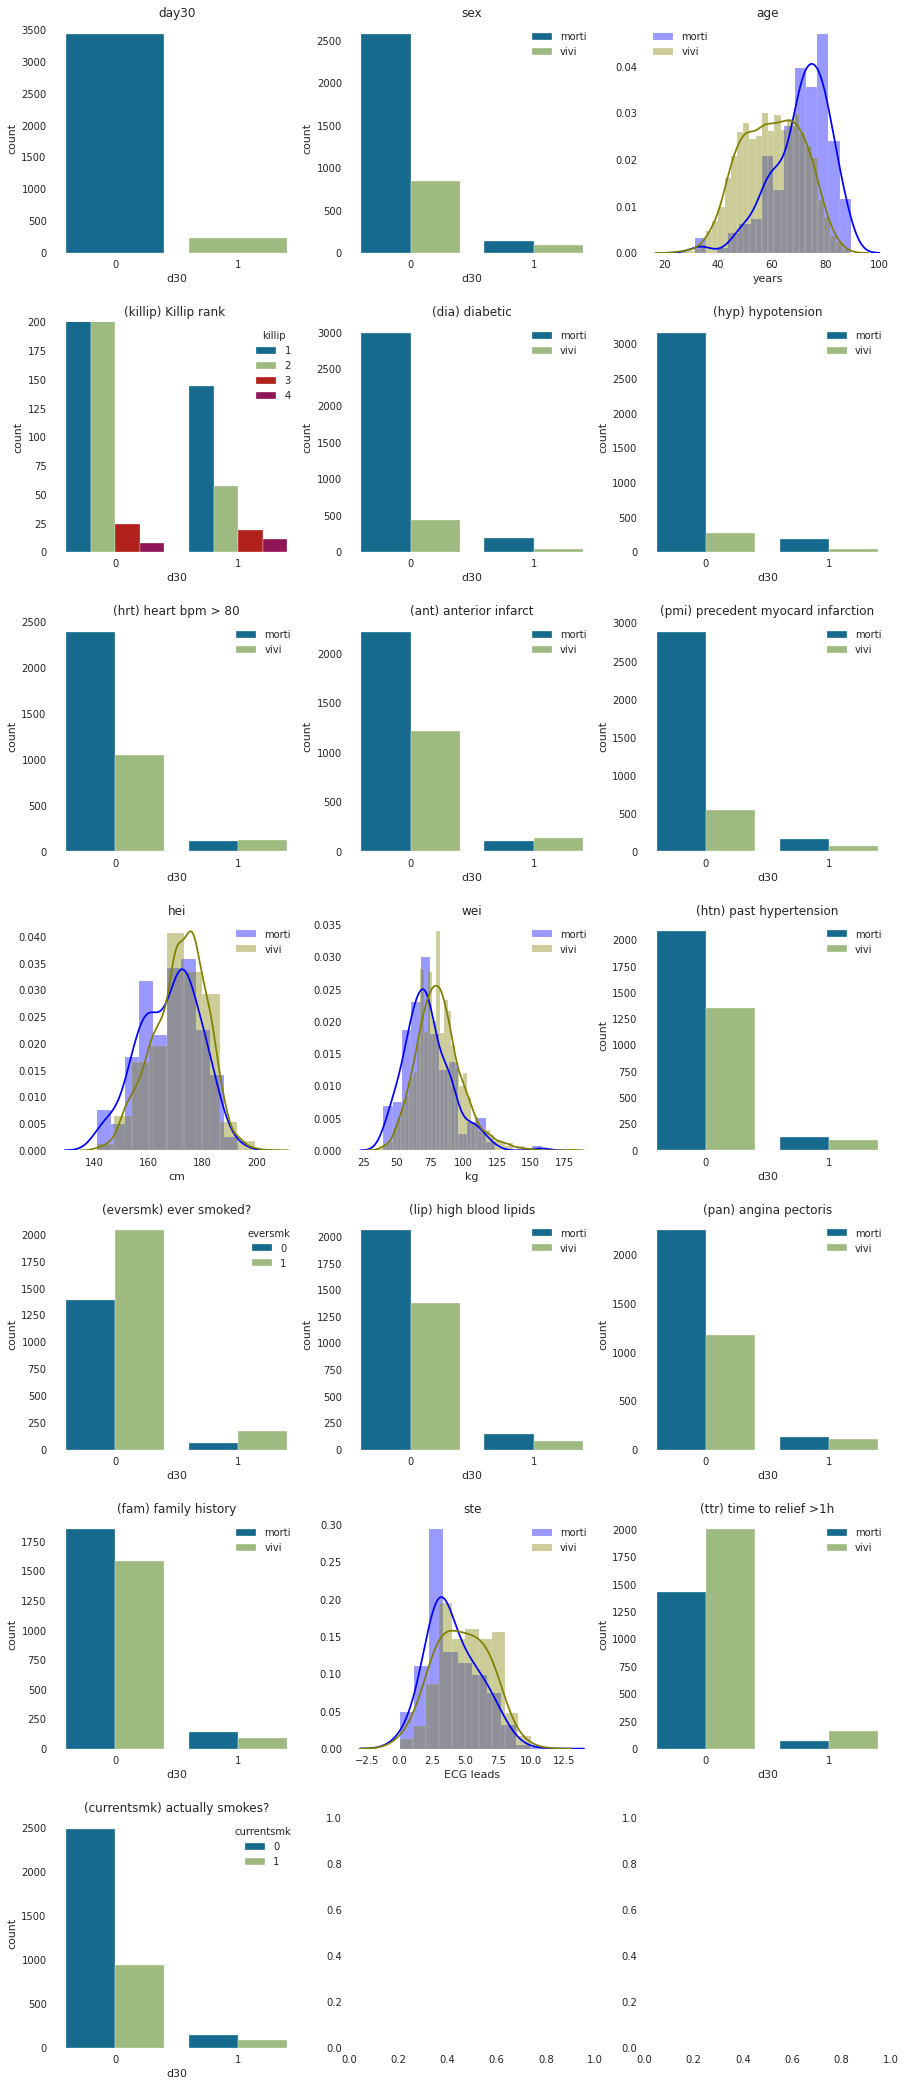

In [6]:
# quick overview
#print(df.describe())


fig, ((a11,a12,a13),
      (a21,a22,a23), 
      (a31,a32,a33),
      (a41,a42,a43),
      (a51,a52,a53),
      (a61,a62,a63),
      (a71,_  ,_  ))= plt.subplots(7,3, figsize=(15,15))


var = "day30"
#a11.hist(df[var], bins=2)
sns.countplot(x='day30',data=df, ax=a11)
a11.set_title(var)
a11.set_xlabel("d30")

sns.countplot(x='day30',hue='sex',data=df, ax=a12)
a12.set_title("sex")
a12.legend(["morti","vivi"])
a12.set_xlabel("d30")

sns.distplot( df.loc[df.day30==1, 'age'] , color="blue", label="0", ax=a13)
sns.distplot( df.loc[df.day30==0, 'age'] , color="olive", label="1", ax=a13)
a13.set_title("age")
a13.set_xlabel("years")
a13.legend(["morti","vivi"])

var = "killip"
a21.set_ylim([0,200])
sns.countplot(x='day30',hue='killip',data=df, ax=a21)
a21.set_title("(killip) Killip rank ")
a21.set_xlabel("d30")

sns.countplot(x='day30',hue='dia',data=df, ax=a22)
a22.set_title("(dia) diabetic")
a22.legend(["morti","vivi"])
a22.set_xlabel("d30")

sns.countplot(x='day30',hue='hyp',data=df, ax=a23)
a23.set_title("(hyp) hypotension")
a23.legend(["morti","vivi"])
a23.set_xlabel("d30")

sns.countplot(x='day30',hue='hrt',data=df, ax=a31)
a31.set_title("(hrt) heart bpm > 80")
a31.legend(["morti","vivi"])
a31.set_xlabel("d30")

sns.countplot(x='day30',hue='ant',data=df, ax=a32)
a32.set_title("(ant) anterior infarct")
a32.legend(["morti","vivi"])
a32.set_xlabel("d30")

sns.countplot(x='day30',hue='pmi',data=df, ax=a33)
a33.set_title("(pmi) precedent myocard infarction")
a33.legend(["morti","vivi"])
a33.set_xlabel("d30")

sns.distplot( df.loc[df.day30==1, 'hei'] , color="blue", label="0", ax=a41, bins=10)
sns.distplot( df.loc[df.day30==0, 'hei'] , color="olive", label="1", ax=a41, bins=10)
a41.set_title("hei")
a41.legend(["morti","vivi"])
a41.set_xlabel("cm")

sns.distplot( df.loc[df.day30==1, 'wei'] , color="blue", label="0", ax=a42)
sns.distplot( df.loc[df.day30==0, 'wei'] , color="olive", label="1", ax=a42)
a42.set_title("wei")
a42.legend(["morti","vivi"])
a42.set_xlabel("kg")

sns.countplot(x='day30',hue='htn',data=df, ax=a43)
a43.set_title("(htn) past hypertension")
a43.legend(["morti","vivi"])
a43.set_xlabel("d30")

sns.countplot(x='day30',hue='eversmk',data=df, ax=a51)
a51.set_title("(eversmk) ever smoked?")
a51.set_xlabel("d30")

sns.countplot(x='day30',hue='lip',data=df, ax=a52)
a52.set_title("(lip) high blood lipids")
a52.legend(["morti","vivi"])
a52.set_xlabel("d30")

sns.countplot(x='day30',hue='pan',data=df, ax=a53)
a53.set_title("(pan) angina pectoris")
a53.legend(["morti","vivi"])
a53.set_xlabel("d30")

sns.countplot(x='day30',hue='fam',data=df, ax=a61)
a61.set_title("(fam) family history")
a61.legend(["morti","vivi"])
a61.set_xlabel("d30")

sns.distplot( df.loc[df.day30==0, 'ste'] , color="blue",   label="0", ax=a62, kde_kws={"bw":1}, bins=10)
sns.distplot( df.loc[df.day30==1, 'ste'] , color="olive", label="1", ax=a62, kde_kws={"bw":1}, bins=10)
a62.set_title("ste")
a62.legend(["morti","vivi"])
a62.set_xlabel("ECG leads")

sns.countplot(x='day30',hue='ttr',data=df, ax=a63)
a63.set_title("(ttr) time to relief >1h")
a63.legend(["morti","vivi"])
a63.set_xlabel("d30")

sns.countplot(x='day30',hue='currentsmk',data=df, ax=a71)
a71.set_title("(currentsmk) actually smokes?")
a71.set_xlabel("d30")


plt.subplots_adjust(wspace = 0.2, hspace=0.3, top=2)

""

## check for multicollinearity

''

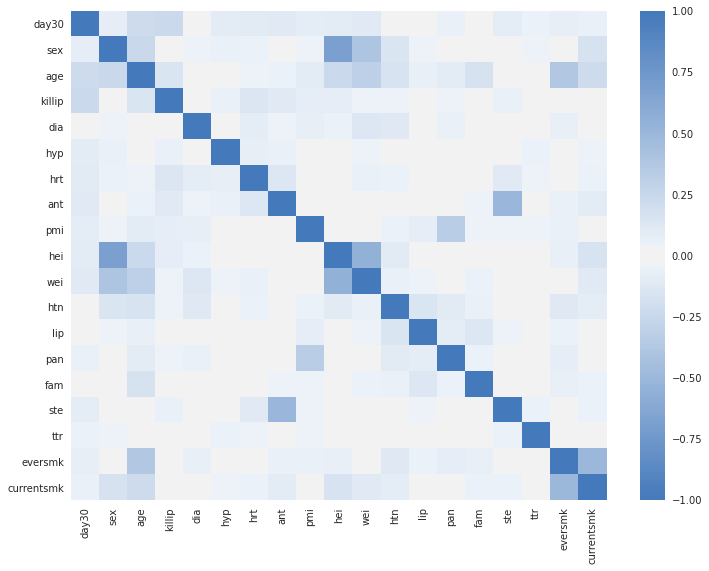

In [7]:
plt.figure(figsize=(12, 9))
sns.heatmap(df.corr(), vmin=-1, vmax=1, cmap=sns.diverging_palette(250, 250, n=256))
''

### $\chi^2$ test

In [44]:
from scipy.stats import chi2_contingency


# commento 1: "test chi² su tabella di contingenza per valori discreti"

for var in ['sex', 'killip', 'dia', 'hyp', 'hrt', 'ant', 'pmi',
         'htn', 'lip', 'pan', 'fam', 'ttr', 'eversmk',
       'currentsmk']:
    contingency = pd.crosstab(df.day30, df[var])
    print(contingency)
    chi2, p, dof, ex = chi2_contingency(contingency, correction=False) # <-  Yates's correction, not used.
    print("\nChi² ={:10.3}".format(chi2))
    print("p    ={:10.2}".format(p))
    print("degrees of freedom = {}".format(dof))
    print("\n","-"*20,"\n")

# commento 1: "test sulle medie per variabili continue"

for var in ['age','wei','hei','ste']:
    from scipy.stats import ttest_ind

    cat1 = df[df['day30']==0]
    cat2 = df[df['day30']==1]

    print(var)
    statistic, pvalue = ttest_ind(cat1[var], cat2[var],equal_var=False)
    print("Welch's t-test statistic = {:5.4}".format(statistic) )
    print("p-value = {:5.4}".format(pvalue))
    print("\n","-"*20,"\n")
    

sex       0    1
day30           
0      2581  849
1       140   91

Chi² =      24.3
p    =   8.2e-07
degrees of freedom = 1

 -------------------- 

killip     1    2   3   4
day30                    
0       3022  376  24   8
1        144   57  19  11

Chi² =  2.41e+02
p    =   6.1e-52
degrees of freedom = 3

 -------------------- 

dia       0    1
day30           
0      2990  440
1       190   41

Chi² =      4.59
p    =     0.032
degrees of freedom = 1

 -------------------- 

hyp       0    1
day30           
0      3156  274
1       186   45

Chi² =      35.9
p    =     2e-09
degrees of freedom = 1

 -------------------- 

hrt       0     1
day30            
0      2387  1043
1       113   118

Chi² =      42.7
p    =   6.3e-11
degrees of freedom = 1

 -------------------- 

ant       0     1
day30            
0      2215  1215
1        99   132

Chi² =      43.9
p    =   3.4e-11
degrees of freedom = 1

 -------------------- 

pmi       0    1
day30           
0      2882  548

Analizzando la correlazione tra variabili, vediamo come alcune coppie di variabili siano correlate:

* age <-> hei <-> sex <-> wei  (prevedibilmente. valutare di unificarle?)
* age <-> smoke  (comprensibilmente)
* currentsmoke <-> eversmoke (è dura smettere)
* age <-> sex  (questa è da indagare)
* ste <-> ant  (anomalie ECG in caso di infarti precedenti?)
* pan <-> pmi  (angina e infarti al miocardio)

## Question 2

*Perform univariable logistic regression analyses, of all candidate predictors for your model. Optional:For Age is the linearity effect reasonable? How could you model alternatively the age effect?



# Univariate logistic regressions

*Perform univariable logistic regressionanalyses, of all candidate predictors for your model. Optional:For Age is the linearity effect reasonable?How could you model alternativelythe age effect?*

In [85]:

for col in ['age', 'hei', 'wei','sex', 'killip', 'dia', 'hyp', 'hrt', 'ant', 'pmi',
        'htn', 'lip', 'pan', 'fam', 'ste', 'ttr', 'eversmk',
       'currentsmk']:
    
        
    
    print("=================================","  " ,str(col), "  ","==================================","\n")
    y, X = dmatrices( 'day30 ~ {}'.format(col), data=df, return_type='dataframe')
    mod = sm.Logit(y, X)
    res = mod.fit()

    print (res.summary())
    print("\nOdds Ratio = {:3.5}".format(np.exp(res.params[1])))
    print("==============================================================================","\n"*4)

    
    
    
    
    
    

=================================    age    ================================== 

Optimization terminated successfully.
         Current function value: 0.207623
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  day30   No. Observations:                 3661
Model:                          Logit   Df Residuals:                     3659
Method:                           MLE   Df Model:                            1
Date:                Fri, 26 Jun 2020   Pseudo R-squ.:                  0.1180
Time:                        12:41:35   Log-Likelihood:                -760.11
converged:                       True   LL-Null:                       -861.82
Covariance Type:            nonrobust   LLR p-value:                 3.728e-46
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -8.8980      

                           Logit Regression Results                           
Dep. Variable:                  day30   No. Observations:                 3661
Model:                          Logit   Df Residuals:                     3659
Method:                           MLE   Df Model:                            1
Date:                Fri, 26 Jun 2020   Pseudo R-squ.:                0.001451
Time:                        12:41:35   Log-Likelihood:                -860.57
converged:                       True   LL-Null:                       -861.82
Covariance Type:            nonrobust   LLR p-value:                    0.1138
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.7891      0.091    -30.627      0.000      -2.968      -2.611
htn            0.2174      0.137      1.588      0.112      -0.051       0.486

Odds Ratio = 1.2428




===========================

## Question 3

*Build  a multivariable  logistic  regression model  starting from the list of significant predictors at univariable analyses. Pay attention to multicollinearity (same variables recoded in different ways).* 

We'll compute a full model, then compute VIF  (Variance Inflation Factor) to estimate collinearity and select the covariates.

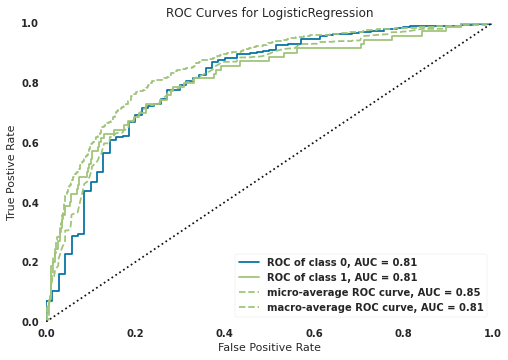

coefficients =
[('sex', -0.21655680148906026),
 ('age', 0.07800675087279615),
 ('killip', 0.830236612979802),
 ('dia', 0.2552722006599578),
 ('hyp', 1.157666677934564),
 ('hrt', 0.6421742717466167),
 ('ant', 0.5711566731428713),
 ('pmi', 0.4263982376104926),
 ('hei', -0.04137024189620959),
 ('wei', -0.0034657765255851256),
 ('htn', -0.10112326898652246),
 ('lip', -0.19826950813837493),
 ('pan', 0.36140357994893474),
 ('fam', -0.009203709514487205),
 ('ste', 0.033512979467863246),
 ('ttr', 0.5463917750985391),
 ('eversmk', -0.0834053782043524),
 ('currentsmk', 0.10739207370409144)]
'intercept: [-0.24554565]'


In [28]:

x_train, x_test, y_train, y_test = train_test_split(df[df.columns[1:]], df['day30'])
weight = 15
fullModel = LogisticRegression(solver='lbfgs', class_weight={0:1,1:weight})
fullModel.fit(x_train, y_train)
rocauc = ROCAUC(fullModel)
rocauc.score(x_test, y_test)  
r = rocauc.poof()

print("coefficients =")
pprint(list(zip(df.columns[1:],fullModel.coef_.tolist()[0])))
pprint("intercept: {}".format(fullModel.intercept_))


In [29]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df[df.columns[1:]].values, i) for i in range(df[df.columns[1:]].shape[1])]
vif["features"] = df[df.columns[1:]].columns
vif

,VIF Factor,features
0,1.751590,sex
1,38.567540,age
2,8.581997,killip
3,1.222906,dia
4,1.125857,hyp
5,1.572605,hrt
6,2.196240,ant
7,1.395508,pmi
8,93.844782,hei
9,36.164083,wei


# removing multicollinear variables

* `age <-> hei <-> sex <-> wei`  (prevedibilmente)
* `age <-> smoke`  (comprensibilmente)
* `age <-> sex`  (questa è da indagare)
* `ste <-> ant`  (anomalie ECG in caso di infarti precedenti?)
* `pan <-> pmi`  (angina e infarti al miocardio)



* Removing: `'hei','wei','age'`, leaving `'sex'` and `'smoke'`
* Removing: `'pan'`, leaving `'pmi'`
* Removing: `'ste'`, leaving `'ant'`

### Feature ranking with recursive feature elimination.

Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a `coef_ attribute` or through a `feature_importances_` attribute. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.



In [30]:
# Feature Extraction with Recurrent Feature Extraction

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
# feature extraction
model = LogisticRegression(solver='lbfgs')
rfe = RFE(model,n_features_to_select=5, step=1)  
fit = rfe.fit(x_train, y_train)
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

Num Features: 5
Selected Features: [ True False  True False  True False  True  True False False False False
 False False False False False False]
Feature Ranking: [ 1 10  1  7  1  4  1  1 11 14  8 13  5 12  9  3  2  6]


In [31]:
# selected: 'sex','killip','hyp','ant','pmi'


#### micro/macro averages in ROC curves:

Micro/macro averages are just features of the library that I use for plotting ROC curves. They are useful only for multiclass settings. When you have a multiclass setting, the average parameter in the score function needs to be one of these:

    'weighted'
    'micro'
    'macro'

The first one, `weighted` calculates the score for each class independently but when it adds them together uses a weight that depends on the number of true labels of each class:

$weighted = score_{class1}∗W_1 + score_{class2}∗W_2+⋅⋅⋅+score_{classN}∗W_N$

therefore favouring the majority class. `micro` uses the global number of TP, FN, FP and calculates the score directly:

$micro = score_{class1+class2+class3}$

no favouring any class in particular. Finally, `macro` calculates the score separated by class but not using weights for the aggregation:

$macro = score_{class1}+F1_{class2}+⋅⋅⋅+score_{classN}$

which resuls in a bigger penalisation when your model does not perform well with the minority classes. The latter is usualy chosen when considering unbalanced classes.

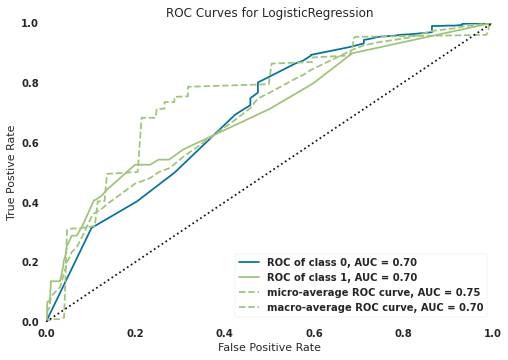

coefficients =
[('sex', 0.841752022984101),
 ('killip', 1.0950677516693492),
 ('hyp', 1.2580718765625793),
 ('ant', 0.9784164025596934),
 ('pmi', 0.7508789039220302)]
'intercept: [-2.47496004]'


In [32]:
# pruned model

selectedCovar=['sex','killip','hyp','ant','pmi']


x_train, x_test, y_train, y_test = train_test_split(df[selectedCovar], df['day30'])
weight = 15
fullModel = LogisticRegression(solver='lbfgs', class_weight={0:1,1:weight})
fullModel.fit(x_train, y_train)
rocauc = ROCAUC(fullModel)
rocauc.score(x_test, y_test)  
r = rocauc.poof()

print("coefficients =")
pprint(list(zip(selectedCovar,fullModel.coef_.tolist()[0])))
pprint("intercept: {}".format(fullModel.intercept_))


# Feature selection

In [ ]:
import itertools
import time
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

%matplotlib inline
plt.style.use('ggplot')

To perform best selection, we fit separate models for each possible combination of the n

predictors and then select the best subset. That is we fit:

* All models that contains exactly one predictor
* All models that contain 2 predictors at the second step: $\binom{n}{2}$
* Until reaching the end point where all $n$ predictors are included in the model


#### Algorithm

* Let $M_0$ denote the null model which contains no predictors, this model simply predicts the sample mean of each observation

    * For $k=1,2,...,n$

    * Fit all $\binom{n}{k}$ models that contain exactly $k$ predictors
    
    * Pick the best among these $\binom{n}{k}$ models, and call it $M_k$. Here the best is defined as having the smallest RSS, or an equivalent measure

    * Select the single best model among "$M_0,M_1,...,M_n$ using cross validated predicton error, $C_p$, $BIC$, $adjusted R^2$ or any other method.
    
    
#### Performance issues:

This algorithm, being $O(\binom n k) $ is simply too huge to compute on any reasonable machine, for more than 5-6 parameters out of 18. It has been run for 1-7 features for demonstrative purposes: run time: ~8h.

In [113]:
# helper: logistic model fitter

def fit_log_reg(X,Y):
    #Fit linear regression model and return RSS and R squared values
    model_k = LogisticRegression(fit_intercept = True)
    model_k.fit(X,Y)
    RSS = mean_squared_error(Y,model_k.predict(X)) * len(Y)
    R_squared = model_k.score(X,Y)
    return RSS, R_squared
#helper: 


In [114]:
#Importing tqdm for the progress bar
from tqdm import tnrange, tqdm_notebook


In [115]:
#Initialization variables
Y = df.day30
X = df.drop(columns = 'day30', axis = 1)
k = 18
RSS_list, R_squared_list, feature_list = [],[], []
numb_features = []

In [129]:
# looping over all possible combinations
import itertools
from sklearn.metrics import mean_squared_error

#Looping over k = 1 to k = 5 features in X
for k in tnrange(1,6, desc = 'Loop...'):

    #Looping over all possible combinations: from 11 choose k
    for combo in itertools.combinations(X.columns,k):
        tmp_result = fit_log_reg(X[list(combo)],Y)   #Store temp result 
        RSS_list.append(tmp_result[0])                  #Append lists
        R_squared_list.append(tmp_result[1])
        feature_list.append(combo)
        numb_features.append(len(combo))   

#Store in DataFrame
res = pd.DataFrame({'numb_features': numb_features,
                   'RSS': RSS_list, 
                   'R_squared':R_squared_list,
                   'features':feature_list})

In [130]:
#get best models
res_min = res[res.groupby('numb_features')['RSS'].transform(min) == res['RSS']]

In [131]:
res_min = res[res.groupby('numb_features')['RSS'].transform(min) == res['RSS']]
res_max = res[res.groupby('numb_features')['R_squared'].transform(max) ==res['R_squared']]
print("min(RSS)")
display(res_min.head(5))
print("\n\nmax(R²)")
display(res_max.head(5))

min(RSS)


,numb_features,RSS,R_squared,features
3,1,228.0,0.937722,"(killip,)"
99,2,222.0,0.939361,"(sho, pmi)"
898,3,220.0,0.939907,"(sho, hyp, pmi)"
4541,4,217.0,0.940727,"(killip, sho, pmi, wei)"
13442,5,215.0,0.941273,"(age, killip, hyp, hrt, ttr)"




max(R²)


,numb_features,RSS,R_squared,features
3,1,228.0,0.937722,"(killip,)"
99,2,222.0,0.939361,"(sho, pmi)"
898,3,220.0,0.939907,"(sho, hyp, pmi)"
4541,4,217.0,0.940727,"(killip, sho, pmi, wei)"
13442,5,215.0,0.941273,"(age, killip, hyp, hrt, ttr)"


In [132]:
res['min_RSS'] = res.groupby('numb_features')['RSS'].transform(min)
res['max_R_squared'] = res.groupby('numb_features')['R_squared'].transform(max)
res.head()

,numb_features,RSS,R_squared,features,min_RSS,max_R_squared
0,1,231.0,0.936902,"(sex,)",228.0,0.937722
1,1,231.0,0.936902,"(age,)",228.0,0.937722
2,1,231.0,0.936902,"(a65,)",228.0,0.937722
3,1,228.0,0.937722,"(killip,)",228.0,0.937722
4,1,231.0,0.936902,"(sho,)",228.0,0.937722


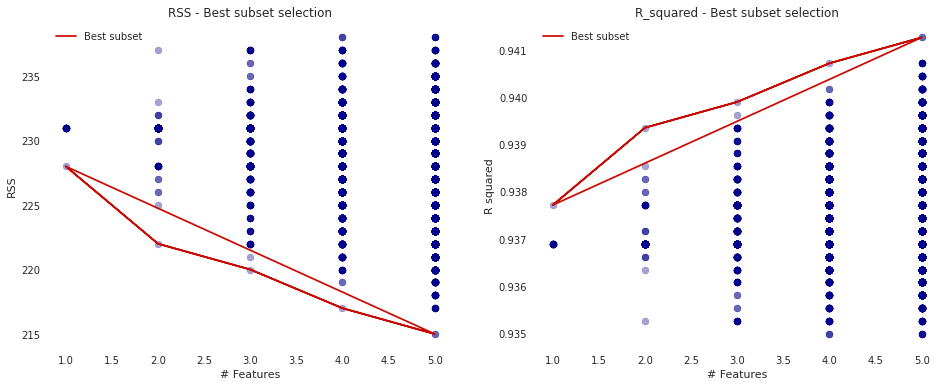

In [133]:
fig = plt.figure(figsize = (16,6))
ax = fig.add_subplot(1, 2, 1)

ax.scatter(res.numb_features,res.RSS, alpha = .2, color = 'darkblue' )
ax.set_xlabel('# Features')
ax.set_ylabel('RSS')
ax.set_title('RSS - Best subset selection')
ax.plot(res.numb_features,res.min_RSS,color = 'r', label = 'Best subset')
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.scatter(res.numb_features,res.R_squared, alpha = .2, color = 'darkblue' )
ax.plot(res.numb_features,res.max_R_squared,color = 'r', label = 'Best subset')
ax.set_xlabel('# Features')
ax.set_ylabel('R squared')
ax.set_title('R_squared - Best subset selection')
ax.legend()

plt.show()


In [33]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df[selectedCovar].values, i) for i in range(df[selectedCovar].shape[1])]
vif["features"] = df[selectedCovar].columns
vif

,VIF Factor,features
0,1.311768,sex
1,2.188681,killip
2,1.105411,hyp
3,1.567508,ant
4,1.206123,pmi


VIF factor looks under control for all selected covariates.

## Question 4 

*Evaluate model performance in discrimination by means of the AUC under the ROC curve. Evaluate also model performance in terms of calibration.* 



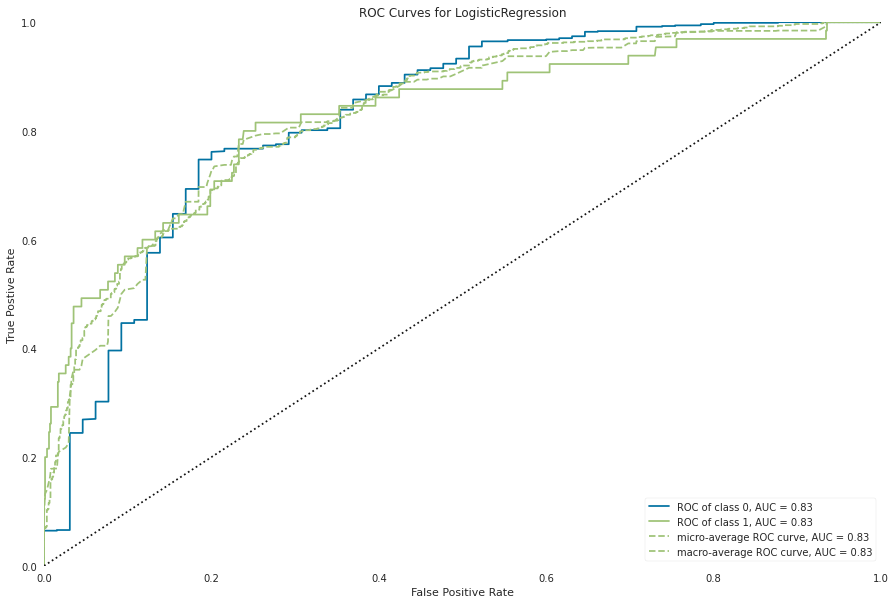

In [136]:
selectedCovar=list(('age', 'killip', 'hyp', 'hrt', 'ttr'))
x_train, x_test, y_train, y_test = train_test_split(df[selectedCovar], df['day30'])

weight = 15

prunedModel = LogisticRegression(solver='lbfgs', class_weight={0:1,1:weight})

prunedModel.fit(x_train, y_train)

rocauc = ROCAUC(prunedModel, size=(1080, 720))

rocauc.score(x_test, y_test)  
r = rocauc.poof()

5) Represent the estimated model by means of a nomogram (hint: R function nomogram {rms})

Niente nomogrammi su python, però ho fatto un widget interattivo.

In [141]:
# age, killip, hyp, hrt, ttr
# pruned model
font = {'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)


print("\n\n        ☠☠☠☠  Death Calculator  ☠☠☠☠ ")

# 'sex','killip','hyp','ant','pmi'

@interact(age=(0,140,1),   # age
          killipClass=(1,4,1),  # killip
          hypotension=False, # hyp
          heartRateOver80BPM=False, # hrt         
          timeToReliefMoreThan1h=False, # ttr
         ) 

def pred( age=0,   # sex
          killipClass=1,  # killip
          hypotension=False, # hyp
          heartRateOver80BPM=False, # hrt          
          timeToReliefMoreThan1h=False, # ttr
        ):
    
    covariates = np.array([age,   # sex
          killipClass,  # killip
          hypotension, # hyp
          heartRateOver80BPM, # hrt          
          timeToReliefMoreThan1h, # ttr
                          ])
    
    prediction = prunedModel.predict([covariates.astype(int)]), 
    prob =       prunedModel.predict_proba([covariates.astype(int)])

  
    #print("covariates:", covariates)
    print("p(p30)= {:.3}%".format(prob[0][1]*100))
    return





        ☠☠☠☠  Death Calculator  ☠☠☠☠ 


interactive(children=(IntSlider(value=0, description='age', max=140), IntSlider(value=1, description='killipCl…

## Question 6

6) Internally validate the estimated model (hint: R function  validate {rms})



In [142]:

X = df[selectedCovar]
y = df[['day30']]

In [143]:
@interact(metric = metrics.SCORERS.keys())

def test(metric):
    clf = LogisticRegressionCV(cv=7, random_state=0, scoring = metric).fit(X, y)
    print("metric: {}, score = {:.4}".format(metric,clf.score(X, y)))

interactive(children=(Dropdown(description='metric', options=('explained_variance', 'r2', 'max_error', 'neg_me…

## Question 7

*Setting  aside  the  interpretability  of  the  model, are  you  able  to  find  a  machine learning algorithm that predicts the risk of event with a similar (or better) performance than the logistic model*

We opted for an XGBoost used to model a logistic regressor, and a K-neighbors classifier.

# XGBoost

In [38]:
df = pd.read_csv("./Gusto.csv")
df['eversmk']= (df['smk']!=1).astype(bool)
df['currentsmk']=(df['smk']==3).astype(bool)
# dummify smk categories
for var in ['day30','sho','dia','hyp','hrt','ant','pmi','htn','lip','pan','fam','ttr']:
    df[var]=df[var].astype(bool)
    
df['killip']=df['killip'].astype(int)

df['sexMale']=df['sex'].apply(lambda x: False if x==0 else True)
    
df.drop(['sex',"smk",'a65','st4'], axis=1, inplace=True)
df

,day30,age,killip,sho,dia,hyp,hrt,ant,pmi,hei,wei,htn,lip,pan,fam,ste,ttr,eversmk,currentsmk,sexMale
0,False,70.313,1,False,False,False,False,True,False,177.3,84.0,True,True,False,False,1,True,True,True,False
1,False,59.844,1,False,True,False,False,True,False,172.0,115.0,True,False,False,True,6,False,False,False,False
2,False,59.023,1,False,False,False,True,False,False,170.0,76.0,True,False,False,True,3,False,False,False,False
3,True,80.375,1,False,False,False,True,False,False,154.9,50.0,False,False,False,False,3,False,True,True,True
4,False,64.750,1,False,False,True,False,False,False,167.0,97.4,False,False,True,True,2,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3656,False,51.836,1,False,False,False,False,True,False,169.8,65.0,False,False,False,False,7,True,False,False,False
3657,False,51.836,1,False,True,False,False,True,False,167.6,72.1,False,False,True,False,7,True,True,True,False
3658,False,63.977,1,False,False,False,False,False,False,174.2,87.2,True,False,False,False,2,True,True,False,False
3659,False,59.758,1,False,False,False,False,False,False,165.0,57.8,False,False,False,False,6,True,True,True,True


In [39]:
x_train, x_test, y_train, y_test = train_test_split(df[df.columns[1:]], df['day30'])

xg_train = xgb.DMatrix(x_train, label=y_train)

n_folds = 5
early_stopping = 10

estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42
)

params = {'eta': [0.03], 
          'max_depth': [2,5,8], 
          'n_estimators' :range(60,220,40),
          'objective': ['binary:logistic'],
          'seed': [99], 
          'silent': [1], 
          'eval_metric':['auc','f1_score'],
          'scale_pos_weight':[1,7,15,100,200,2000]}

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=params,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 10,
    verbose=True
)

grid_search.fit(x_train, y_train)

Fitting 10 folds for each of 144 candidates, totalling 1440 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    2.3s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   19.8s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:  1.2min
[Parallel(n_jobs=10)]: Done 786 tasks      | elapsed:  3.2min


[16:59:26] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[Parallel(n_jobs=10)]: Done 1440 out of 1440 | elapsed:  3.2min finished


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_job...
                                     scale_pos_weight=None, seed=42,
                                     subsample=None, tree_method=None,
                                     validate_parameters=None, verbosity=None),
             n_jobs=10,
             param_grid={'eta': [0.03],

best metrics: 



In [40]:
grid_search.best_estimator_.scale_pos_weight

#apparently, XGBoost performs better without class weighting...

1

In [41]:
for x in [x_train, x_test, y_train, y_test]:
    print (x.shape)

clf=grid_search.best_estimator_
clf.scale_pos_weight=15

xgb_param = clf.get_xgb_params()

clf.fit(x_train, y_train)

(2745, 19)
(916, 19)
(2745,)
(916,)
[16:59:26] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.03,
              eval_metric='auc', gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.0299999993,
              max_delta_step=0, max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=180, n_jobs=4, nthread=4,
              num_parallel_tree=1, random_state=99, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=15, seed=99, silent=1, subsample=1,
              tree_method='exact', validate_parameters=1, ...)

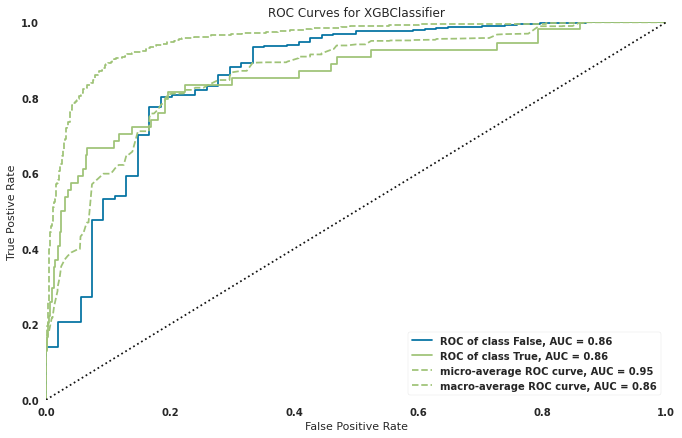

In [42]:
from yellowbrick.classifier import ROCAUC


plots = []
for index,pl in enumerate([ROCAUC]):
    ax = plt.subplot()
    g = pl(clf, size=(800, 500))
    g.fit(x_train,y_train)
    g.score(x_test,y_test)  
    ax = g.poof(size=(1080,720), silent=True)

**Queue Rate**: The “queue” is the spam folder or the inbox of the fraud investigation desk. This metric describes the percentage of instances that must be reviewed. If review has a high cost (e.g. fraud prevention) then this must be minimized with respect to business requirements; if it doesn’t (e.g. spam filter), this could be optimized to ensure the inbox stays clean.

# K-N classifier

hyperparameters were optimized by genetic programming gridsearch on a separeted code, but they are very robust.

In [47]:
df = pd.read_csv("./Gusto.csv")
df['eversmk']= (df['smk']!=1).astype(bool)
df['currentsmk']=(df['smk']==3).astype(bool)
# dummify smk categories
for var in ['day30','sho','dia','hyp','hrt','ant','pmi','htn','lip','pan','fam','ttr']:
    df[var]=df[var].astype(bool)
    
df['killip']=df['killip'].astype(int)

df['sexMale']=df['sex'].apply(lambda x: False if x==0 else True)
    
df.drop(['sex',"smk",'a65','st4'], axis=1, inplace=True)
df

,day30,age,killip,sho,dia,hyp,hrt,ant,pmi,hei,wei,htn,lip,pan,fam,ste,ttr,eversmk,currentsmk,sexMale
0,False,70.313,1,False,False,False,False,True,False,177.3,84.0,True,True,False,False,1,True,True,True,False
1,False,59.844,1,False,True,False,False,True,False,172.0,115.0,True,False,False,True,6,False,False,False,False
2,False,59.023,1,False,False,False,True,False,False,170.0,76.0,True,False,False,True,3,False,False,False,False
3,True,80.375,1,False,False,False,True,False,False,154.9,50.0,False,False,False,False,3,False,True,True,True
4,False,64.750,1,False,False,True,False,False,False,167.0,97.4,False,False,True,True,2,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3656,False,51.836,1,False,False,False,False,True,False,169.8,65.0,False,False,False,False,7,True,False,False,False
3657,False,51.836,1,False,True,False,False,True,False,167.6,72.1,False,False,True,False,7,True,True,True,False
3658,False,63.977,1,False,False,False,False,False,False,174.2,87.2,True,False,False,False,2,True,True,False,False
3659,False,59.758,1,False,False,False,False,False,False,165.0,57.8,False,False,False,False,6,True,True,True,True


In [48]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from tpot.export_utils import set_param_recursive

# NOTE: Make sure that the outcome column is labeled 'target' in the data file
tpot_data = df
features = tpot_data.drop('day30', axis=1)
x_train, x_test, y_train, y_test = train_test_split(df[df.columns[1:]], df['day30'])

# Average CV score on the training set was: 0.9522768670309654
exported_pipeline = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier(n_neighbors=50, p=2, weights="distance")
)
# Fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline.steps, 'random_state', 42)

exported_pipeline.fit(x_train, y_train)
results = exported_pipeline.predict(x_test)

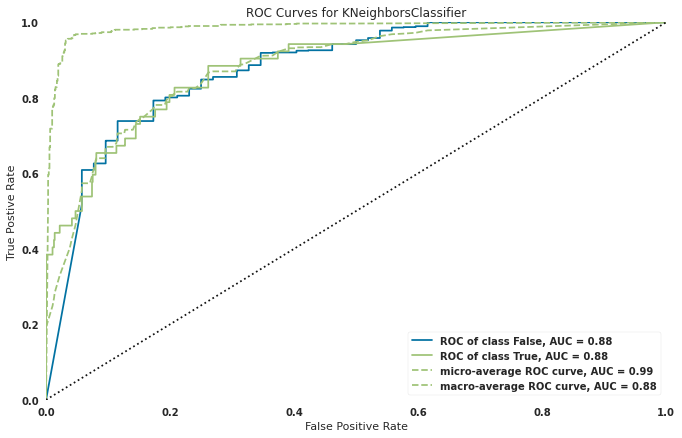

In [49]:
from yellowbrick.classifier import ROCAUC


plots = []
for index,pl in enumerate([ROCAUC]):
    ax = plt.subplot()
    g = pl(exported_pipeline, size=(800, 500))
    g.fit(x_train, y_train)
    g.score(x_test,y_test)  
    ax = g.poof(size=(1080,720))

*8) Machine learning: mi spieghi meglio, quali variabili hai "dato in pasto" a xgboost? qui poi ti farò io delle domande, ma solo x capire meglio...anche il discorso della figura (mostra la ROC sia su training che su test?)*

Ad XGBoost ho dato indiscriminatamente in pasto tutte le variabili (meno le labels ovviamente). La ROC è calcolata solo sul test set. `g.score(x_test,y_test)`